### Authors: Matthew Newton, Ly Nguyenova

# Executive Summary

This report aims to examine the University of Wisconsin - Madison Courses and Grades 2006-2017 dataset and to analyse whether STEM, humanity subjects, teachers and days have any statiscally significant correlation with the number of As given in courses in University of Wisconsin - Madison.

The hypotheses needed to be answered are:

Does your teacher have a statistically significant correlation with the number on A's earned in a course?
Does time of day have a statistically significant correlation with the number of A's earned in a course?
Do STEM fields have a statistically significant difference in the number of A's earned when compared to the humanities?

For all these hypotheses, one sample t-tests, two sample t-tests and ANOVA tests, i.e. Tukey HSD were implemented. The findings can be listed as below:

Science & Engineering obtains statistically more "As" than the Humanities & Social Science

STEM instructor - Donald Yandow has no statistically significant correlation with the number of As earned in his courses

Humanities instructor - Ida Trudell has a statistically significant correlation with the number of As earned in her courses

Directed Studies. labs and lectures seem to have a statistically significant correlation with the number of As earned in her courses


## Importing libraries

In [1]:
# Import Libraries:
import numpy as np
import pandas as pd

# Statistics Libraries:
import scipy.stats as stats
import statsmodels as sm
from statsmodels.formula.api import ols
import itertools

# Ploting Libraries:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# SQL
import sqlite3 
conn = sqlite3.connect('database.sqlite3')
cur = conn.cursor()

## Common Functions

In [2]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    return sample

def get_sample_mean(sample):
    return sum(sample)/len(sample)

def create_sample_distribution(data, dist_size=100, n=30):
    sample_distribution_means = []
    while len(sample_distribution_means) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_distribution_means.append(sample_mean)
    return sample_distribution_means

In [3]:
def one_sample_ttest(sample, popmean, alpha):

    # Visualize sample distribution for normality 
    #binsize = int(len(sample)/3)
    #sns.distplot(sample, bins=binsize)
    
    # Population mean
    mu = popmean

    # Sample mean (x̄) using NumPy mean()
    x_bar = np.mean(sample)

    # Sample Standard Deviation (sigma) using Numpy
    sample_std = np.std(sample)
    
    # Degrees of freedom
    dof = len(sample)-1
    
    # Calculate the critical t-value
    t_crit = stats.t.ppf(1- alpha, dof)
   
    # Calculate the t-value and p-value      t = (x_bar - mu)/(sample_std/math.sqrt(len(sample)))
    t1, p1 = stats.ttest_1samp(sample, mu)
    
    if (abs(t1)>t_crit) and (p1<alpha):
        print("Reject Null_H! The results are statistically significant.")
        print("Mean Diff:", mu-x_bar)
        print("t-stat = ", round(t1,3), "\nt_crit", round(t_crit,3), "\nP_value = ", round(p1,3), "\nAlpha", alpha)
    
    else:
        print("Do NOT Reject Null_H. The results are NOT statistically significant.")
        rint("Mean Diff:", mu-x_bar)
        print("t-stat = ", round(t1,3), "\nt_crit", round(t_crit,3), "\nP_value = ", round(p1,3), "\nAlpha", alpha)
     
    # return results
    return None

In [4]:
def two_sample_ttest(sample1, sample2, alpha):
    n_sample1 = len(sample1)
    n_sample2 = len(sample2)
    t_stat, P_value = stats.ttest_ind(sample1, sample2)
    t_crit = stats.t.ppf(1-(alpha/2), (n_sample1+n_sample2-2))
    
    mean_sample1 = round((sum(sample1)/n_sample1),3)
    mean_sample2 = round((sum(sample2)/n_sample2),3)
    mean_diff = round(abs(mean_sample1 - mean_sample2),3)
    
    # Outputs:
    print("Two Tail T-test:")
    print("---------------------------------------------------------------")
    print(f"Obs Number: Sample_1 = {n_sample1}   Sample_2 = {n_sample2}")
    print(f"Sample Means: Sample_1 = {mean_sample1}   Sample_2 = {mean_sample2}")
    print(f"Mean Differance: {mean_diff}")
#     sns.distplot(sample1), sns.distplot(sample2)
    print("---------------------------------------------------------------")
    print(f"t-crit: {t_crit} \nt-stat: {t_stat} \nP-value: {P_value} \nAlpha(2-Tail): {alpha/2}")
    print("---------------------------------------------------------------")
    
    if (abs(t_stat) > t_crit) and (P_value < (alpha/2)):
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value < Alpha(2-Tail):", (P_value < alpha))
        print("\nReject Null_H! The results are statistically significant.")
        
    else:
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value < Alpha(2-Tail):", (P_value < (alpha/2)))
        print("\nDo NOT Reject Null_H. The results are NOT statistically significant.")
    
    print("---------------------------------------------------------------")

    return None

In [5]:
from statsmodels.stats.power import TTestIndPower

def power_and_effect_size(sample1, sample2, alpha):
    n_sample1 = len(sample1)
    n_sample2 = len(sample2)
    mean_sample1 = get_sample_mean(sample1)
    mean_sample2 = get_sample_mean(sample2)
    dof = n_sample1 + n_sample2 - 2
    nobs = (n_sample1 + n_sample2)/2
    
    # cohen_d_ES:
    ES = (mean_sample1 - mean_sample2) / np.sqrt(((n_sample1-1)*np.std(sample1, ddof=1) ** 2 + (n_sample2-1)*np.std(sample2, ddof=1) ** 2) / dof)
    
    # TTestPower
    power = sm.stats.power.tt_ind_solve_power(effect_size=ES, 
                                              nobs1=nobs, 
                                              alpha=alpha, 
                                              ratio=(n_sample1/n_sample2),
                                              alternative='two-sided')
    
    return round(abs(ES),2), power

## Q1: Do STEM fields have a statistically significant difference in the number of A's earned when compared to the humanities?

#### Null Hypothesis

The number for A's achieved is NOT related to the subject field.

𝐻0:𝜇𝑆𝑇𝐸𝑀=𝜇𝐻𝑢𝑚𝑎𝑛𝑖𝑡𝑖𝑒𝑠 

#### Alternative Hypothesis

The number for A's achieved is related to the subject field.

𝐻𝐴:𝜇𝑆𝑇𝐸𝑀≠𝜇𝐻𝑢𝑚𝑎𝑛𝑖𝑡𝑖𝑒𝑠 

#### Method

In [6]:
cur.execute("""SELECT F.name AS instructor, section_type, D.name AS CourseName, H.name AS SubjectName, 
                a_count, b_count, c_count, d_count, f_count, u_count
                
                FROM [teachings] A
                
                JOIN [sections] B
                ON (A.section_uuid = B.uuid)
                JOIN [course_offerings] C
                ON (B.course_offering_uuid = C.uuid)
                JOIN [courses] D
                ON (C.course_uuid = D.uuid)
                JOIN [grade_distributions] E
                ON ((B.course_offering_uuid = E.course_offering_uuid))
                JOIN [instructors] F
                ON (A.instructor_id = F.id)
                JOIN [subject_memberships] G
                ON (B.course_offering_uuid = G.course_offering_uuid)
                JOIN [subjects] H
                ON (G.subject_code = H.code)
                
                ORDER BY instructor
                """)
df_teachings = pd.DataFrame(cur.fetchall())
df_teachings.columns = [x[0] for x in cur.description]
df_teachings.head(20)

,instructor,section_type,CourseName,SubjectName,a_count,b_count,c_count,d_count,f_count,u_count
0,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),6,4,0,0,0,0
1,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,6,4,0,0,0
2,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),8,0,0,0,0,0
3,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,3,2,1,0,0
4,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,1,1,1,1,0
5,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),17,0,0,0,0,0
6,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),16,0,0,0,0,0
7,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),5,4,0,0,0,0
8,JR. JAMES BROWN,LEC,Bascom Course,ENGLISH,8,2,3,0,0,0
9,JR. JAMES BROWN,LEC,Bascom Course,ENGLISH,6,2,0,0,0,0


In [7]:
df_teachings.shape

(2206765, 10)

In [8]:
np.array(list(df_teachings.a_count))

array(['6', '5', '8', ..., '5', '5', '5'], dtype='<U3')

#### Find the population mean

In [9]:
# As the grades are strings, they need to be converted to integers
def convert_to_integer(data):
    integers = []
    for i in data:
        integers.append(int(i))
    return integers

In [10]:
df_teachings.a_count = convert_to_integer(df_teachings.a_count)
df_teachings.b_count = convert_to_integer(df_teachings.b_count)
df_teachings.c_count = convert_to_integer(df_teachings.c_count)
df_teachings.d_count = convert_to_integer(df_teachings.d_count)
df_teachings.f_count = convert_to_integer(df_teachings.f_count)
df_teachings.u_count = convert_to_integer(df_teachings.u_count)

In [11]:
popmean = np.mean(df_teachings.a_count)
popmean

7.296120339048335

#### Produce lists for STEM, humanity and medical subjects

In [12]:
subjects = sorted(set(list(df_teachings.SubjectName)))
print("Number of Subjects:", len(subjects))
# subjects

Number of Subjects: 193


In [13]:
STEM = ['Biochemistry',
 'Biological Systems Engineering',
 'Biology',
 'Biology Core Curriculum',
 'Biomedical Engineering',
 'Biomolecular Chemistry',
 'Biostatistics and Medical Informatics','CLINICAL LABORATORY SCIENCE',
 'Cell and Regenerative Biology',
 'Chemical and Biological Engineering',
 'Chemistry', 'Computer Sciences', 'Economics','Electrical and Computer Engineering',
 'Engineering Mechanics and Astronautics',
 'Engineering Physics',
 'Engineering Professional Development','Geological Engineering','Industrial and Systems Engineering',
    'Materials Science and Engineering',
 'Mathematics',
 'Mechanical Engineering',
 'Microbiology','Molecular Biology',
 'Molecular and Environmental Toxicology Center',
 'Nuclear Engineering','Physics','Science and Technology Studies','Soil Science','Statistics','WILDLIFE ECOLOGY',
 'Zoology']

In [14]:
HUM = ['Art Department',
 'Art Education (Department of Art)',
 'Art History',
 'Asian American Studies','Anthropology','Chicana/o and Latina/o Studies',
 'Civil Society and Community Studies','Classics','Communication Arts',
 'Communication Sciences and Disorders',
 'Community and Environmental Sociology','Comparative Literature','Counseling Psychology','ENGLISH',
 'East Asian Area Studies',
 'East Asian Languages and Literature','English','FAMILY AND CONSUMER COMMUNICATIONS','Gender and Women’s Studies',
       'Greek (Classics)','History','Integrated Arts',
 'Integrated Liberal Studies', 'Latin (Classics)',
 'Latin American, Caribbean, and Iberian Studies',
 'Law',
 'Legal Studies','Literature in Translation','Political Science','Psychiatry',
 'Psychology','Religious Studies','Sociology','Theatre and Drama']

In [15]:
Medical = ['Anatomy',
 'Anesthesiology','Emergency Medicine','Medical Genetics',
 'Medical History and Bioethics',
 'Medical Microbiology and Immunology',
 'Medical Physics',
 'Medical Sciences - Medical School',
 'Medical Sciences - Veterinary Medicine',
 'Medicine','Neurological Surgery',
 'Neurology',
 'Neuroscience',
 'Neuroscience Training Program','Oncology', 'Obstetrics and Gynecology', 'Ophthalmology and Visual Sciences',
          'Patho-Biological Sciences',
 'Pathology and Laboratory Medicine',
 'Pediatrics',
 'Pharmaceutical Sciences',
 'Pharmacology',
 'Pharmacy',
 'Pharmacy Practice','Physical Therapy',
 'Physician Assistant Program','Radiology','Rehabilitation Medicine',
 'Rehabilitation Psychology and Special Education','Senior Medical Program','Surgery',
 'Surgical Sciences',]

### One-sample T-test

We can use a one sample t-test as we know what the population mean is of the whole university. Therefore, comparing the the samples of Science & Engineering, Humanities & Social Science & Medical, groups against the the entire school.

#### STEM

In [16]:
df_STEM = df_teachings[df_teachings['SubjectName'].isin(STEM)]
df_STEM

,instructor,section_type,CourseName,SubjectName,a_count,b_count,c_count,d_count,f_count,u_count
406,- EKTA,LAB,Introduction to Data Programming,Computer Sciences,40,43,5,1,2,0
407,- EKTA,LAB,Introduction to Data Programming,Computer Sciences,41,31,4,2,1,0
408,. ABHINAVA,DIS,General Physics,Physics,71,81,5,0,1,0
409,. ABHINAVA,DIS,General Physics,Physics,32,51,10,1,1,0
410,. ABHINAVA,DIS,General Physics,Physics,71,81,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2206760,ZZ RIFORD,DIS,Dynamics,Mechanical Engineering,10,18,5,3,2,0
2206761,ZZ RIFORD,DIS,Dynamics,Mechanical Engineering,12,13,5,2,1,0
2206762,null,LEC,Structural Theories of Fluid Dynamics,Chemical and Biological Engineering,5,2,0,0,0,0
2206763,null,LEC,Structural Theories of Fluid Dynamics,Chemistry,5,2,0,0,0,0


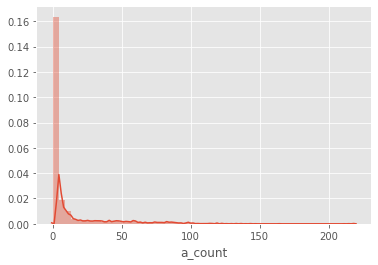

In [17]:
sns.distplot(df_STEM.a_count)

In [18]:
print("NormTest:", stats.normaltest(df_STEM.a_count))

NormTest: NormaltestResult(statistic=494394.39789904223, pvalue=0.0)


In [19]:
df_STEM.shape

(786388, 10)

In [20]:
AsSTEM = create_sample_distribution(df_STEM.a_count, 20000, 50)

In [21]:
popmean - np.mean(AsSTEM)

-1.7847866609516645

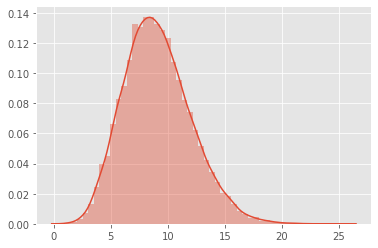

In [22]:
sns.distplot(AsSTEM)

In [23]:
print(stats.normaltest(AsSTEM))
print("Skewness:", stats.skewtest(AsSTEM), 
      "\nKurtosis:", stats.kurtosistest(AsSTEM))

NormaltestResult(statistic=671.1416930952937, pvalue=1.8341424259912597e-146)
Skewness: SkewtestResult(statistic=24.960355900279964, pvalue=1.648384231983129e-137) 
Kurtosis: KurtosistestResult(statistic=6.93702576228839, pvalue=4.004408270562283e-12)


In [24]:
t_STEM, p_STEM = stats.ttest_1samp(AsSTEM, popmean)
print("STEM: \nT_stat:", t_STEM, "\np_value:", p_STEM)

STEM: 
T_stat: 86.04321880998518 
p_value: 0.0


#### Humanity Subjects

In [25]:
df_HUM = df_teachings[df_teachings['SubjectName'].isin(HUM)]

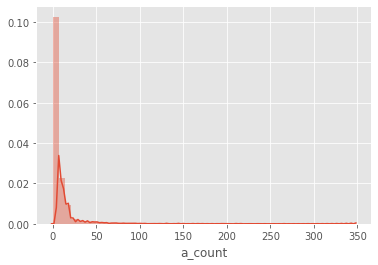

In [26]:
sns.distplot(df_HUM.a_count)

In [27]:
df_HUM.shape

(495381, 10)

In [28]:
AsHUM = create_sample_distribution(df_HUM.a_count, 20000, 50)

In [29]:
popmean - np.mean(AsHUM)

0.3189953390483353

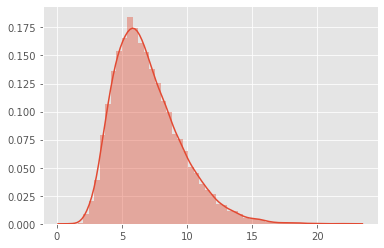

In [30]:
sns.distplot(AsHUM)

In [31]:
print(stats.normaltest(AsHUM))
print("Skewness:", stats.skewtest(AsHUM), 
      "\nKurtosis:", stats.kurtosistest(AsHUM))

NormaltestResult(statistic=2658.758215818139, pvalue=0.0)
Skewness: SkewtestResult(statistic=46.298335538335145, pvalue=0.0) 
Kurtosis: KurtosistestResult(statistic=22.698509691120076, pvalue=4.6344025871128266e-114)


In [32]:
t_HUM, p_HUM = stats.ttest_1samp(AsHUM, popmean)
print("HUM: \nT_stat:", t_HUM, "\np_value:", p_HUM)

HUM: 
T_stat: -17.577929873705592 
p_value: 1.1939635399623487e-68


In [33]:
one_sample_ttest(AsSTEM, popmean, 0.05)

Reject Null_H! The results are statistically significant.
Mean Diff: -1.7847866609516645
t-stat =  86.043 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05


In [34]:
one_sample_ttest(AsHUM, popmean, 0.05)

Reject Null_H! The results are statistically significant.
Mean Diff: 0.3189953390483353
t-stat =  -17.578 
t_crit 1.645 
P_value =  0.0 
Alpha 0.05


#### Medical

In [35]:
df_Medical = df_teachings[df_teachings['SubjectName'].isin(Medical)]

In [36]:
df_Medical.shape

(243021, 10)

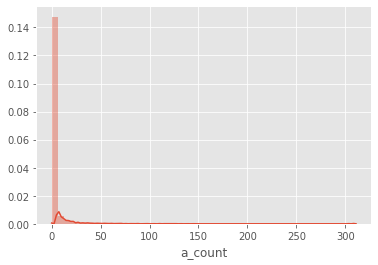

In [37]:
sns.distplot(df_Medical.a_count)

In [38]:
AsMedical = create_sample_distribution(df_Medical.a_count, 20000, 50)

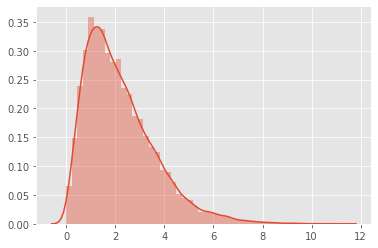

In [39]:
sns.distplot(AsMedical)

In [40]:
print(stats.normaltest(AsMedical))
print("Skewness:", stats.skewtest(AsMedical), 
      "\nKurtosis:", stats.kurtosistest(AsMedical))

NormaltestResult(statistic=3812.2139496196737, pvalue=0.0)
Skewness: SkewtestResult(statistic=54.648131959447575, pvalue=0.0) 
Kurtosis: KurtosistestResult(statistic=28.736659913122793, pvalue=1.3296530352227847e-181)


In [41]:
t_Medical, p_Medical = stats.ttest_1samp(AsMedical, popmean)
print("HUM: \nT_stat:", t_Medical, "\np_value:", p_Medical)

HUM: 
T_stat: -506.80603372468784 
p_value: 0.0


### Comparison between Science & Engineering and Humanities & Social Science using Two-Sample T-Tests:

Students-T as the are equal samples due to the get samples

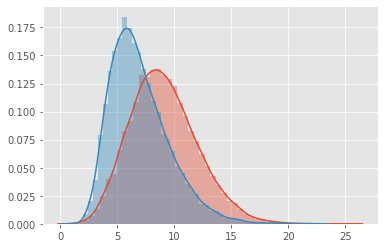

In [42]:
sns.distplot(AsSTEM)
sns.distplot(AsHUM)

In [43]:
def find_t_crit(sample1, sample2, alpha):
    return stats.t.ppf(1-(alpha/2), (len(sample1)+len(sample2)-2))

In [44]:
find_t_crit(AsSTEM, AsHUM, 0.05)

1.9600232960505766

In [45]:
def two_sample_ttest_student_t(sample1, sample2, alpha):
    return stats.ttest_ind(sample1, sample2, equal_var=False)

In [46]:
two_sample_ttest_student_t(AsSTEM, AsHUM, 0.05)

Ttest_indResult(statistic=76.33229719350898, pvalue=0.0)

In [47]:
two_sample_ttest(AsSTEM, AsHUM, 0.05)
ES, power = power_and_effect_size(AsSTEM, AsHUM, 0.05)
print("Cohen_d Effect Size:", ES, "\nPower:", power)

Two Tail T-test:
---------------------------------------------------------------
Obs Number: Sample_1 = 20000   Sample_2 = 20000
Sample Means: Sample_1 = 9.081   Sample_2 = 6.977
Mean Differance: 2.104
---------------------------------------------------------------
t-crit: 1.9600232960505766 
t-stat: 76.33229719350898 
P-value: 0.0 
Alpha(2-Tail): 0.025
---------------------------------------------------------------
|t_stat| > t_crit: True
P_value < Alpha(2-Tail): True

Reject Null_H! The results are statistically significant.
---------------------------------------------------------------
Cohen_d Effect Size: 0.76 
Power: 1.0


### Conclusions

Science & Engineering obtains statistically more "As" than the Humanities & Social Science

## Q2: Does you teacher have a statistically significant correalation with the number of As earned in a course?

#### Null Hypothesis 

The teacher has NO correlation with the number of As earned in a course

#### Alternative Hypothesis

The teacher does affect the As earned in a course

In [63]:
cur.execute("""SELECT * FROM grade_distributions;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,u_count,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,0,0,0,0,0,0,0,0,0,0,0,105,0,0,0,0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,0,0,0,0,0,0,0,0,0,0,0,158,0,1,0,0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,0,0,12,139,0,0,2,0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,0,0,0,0,0,0,0,0,0,0,0,87,0,1,0,0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,0,0,0,0,0,0,0,0,0,0,0,70,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193257,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193258,a7863f8b-0bbf-33e9-b857-2a42bb6b809f,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193259,3573e335-e7be-33a6-b023-8704b3acc93b,1,0,0,0,0,0,0,0,0,0,0,7,18,0,0,0,0
193260,13278922-0726-3823-abda-dc14df03d8a6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df.describe()

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,u_count,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count
count,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262,193262
unique,80171,304,14,122,33,14,23,15,13,105,6,56,154,273,120,38,184,34
top,36754980-48d2-3b34-ad0c-d621a6cb30df,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,60,61765,192786,163253,179496,192881,192373,191286,191613,158436,192696,177456,125376,106961,176796,185488,134512,190919


In [65]:
cur.execute("""SELECT instructors.id, instructors.name, grade_distributions.a_count, course_offerings.name AS course_name, subjects.name AS subjects_name FROM instructors 
            JOIN teachings ON instructors.id = teachings.instructor_id
            JOIN sections ON teachings.section_uuid = sections.uuid
            JOIN grade_distributions ON sections.course_offering_uuid = grade_distributions.course_offering_uuid
            LEFT JOIN course_offerings ON sections.course_offering_uuid = course_offerings.uuid
            JOIN subject_memberships ON sections.course_offering_uuid = subject_memberships.course_offering_uuid
            JOIN subjects ON subject_memberships.subject_code = subjects.code;""")
teachings = pd.DataFrame(cur.fetchall())
teachings.columns = [x[0] for x in cur.description]
teachings

,id,name,a_count,course_name,subjects_name
0,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Biomedical Engineering
1,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Chemical and Biological Engineering
2,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Civil and Environmental Engineering
3,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Electrical and Computer Engineering
4,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Engineering Mechanics and Astronautics
...,...,...,...,...,...
2206760,884262,ARLYNE JOHNSON,18,Conservation Planning,Environmental Studies - Gaylord Nelson Institute
2206761,5906028,ALICIA BARCEINAS CRUZ,18,Conservation Planning,Environmental Studies - Gaylord Nelson Institute
2206762,5906028,ALICIA BARCEINAS CRUZ,18,Conservation Planning,Environmental Studies - Gaylord Nelson Institute
2206763,3296435,SARAH SULLIVAN,0,Patient Ed. as Advocacy Strat.,Surgery


In [66]:
teachings["subjects_name"].isna().any()

False

In [67]:
sorted(list(teachings["subjects_name"].unique()))

['ANIMAL HEALTH AND BIOMEDICAL SCIENCES',
 'Accounting and Information Systems',
 'Actuarial Science',
 'African Languages and Literature',
 'Afro-American Studies',
 'Agricultural and Applied Economics',
 'Agroecology',
 'Agronomy',
 'Air Force Aerospace Studies',
 'American Indian Studies',
 'Anatomy',
 'Anesthesiology',
 'Animal Sciences',
 'Anthropology',
 'Art Department',
 'Art Education (Department of Art)',
 'Art History',
 'Asian American Studies',
 'Astronomy',
 'Atmospheric and Oceanic Sciences',
 'Biochemistry',
 'Biological Systems Engineering',
 'Biology',
 'Biology Core Curriculum',
 'Biomedical Engineering',
 'Biomolecular Chemistry',
 'Biostatistics and Medical Informatics',
 'Botany',
 'CLINICAL LABORATORY SCIENCE',
 'Cell and Regenerative Biology',
 'Chemical and Biological Engineering',
 'Chemistry',
 'Chicana/o and Latina/o Studies',
 'Civil Society and Community Studies',
 'Civil and Environmental Engineering',
 'Classics',
 'Collaborative Nursing Program',
 'Comm

In [68]:
teachings["subjects_name"].nunique()

193

In [162]:
print(len(STEM))
print(len(HUM))

32
34


In [163]:
df_STEM = teachings[teachings["subjects_name"].isin(STEM1)]
df_STEM.head(50)

,id,name,a_count,course_name,subjects_name
0,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Biomedical Engineering
1,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Chemical and Biological Engineering
2,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Civil and Environmental Engineering
3,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Electrical and Computer Engineering
4,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Engineering Mechanics and Astronautics
5,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Industrial and Systems Engineering
6,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Mechanical Engineering
7,761703,JOHN ARCHAMBAULT,105,Cooperative Education Prog,Materials Science and Engineering
8,761703,JOHN ARCHAMBAULT,158,Cooperative Education Prog,Biomedical Engineering
9,761703,JOHN ARCHAMBAULT,158,Cooperative Education Prog,Chemical and Biological Engineering


In [73]:
def convert_to_integer(data):
    integers = []
    for i in data:
        integers.append(int(i))
    return integers

teachings["a_count"] = convert_to_integer(teachings["a_count"])

In [74]:
#finding the mean of the population
import numpy as np
popmean = np.mean(teachings["a_count"])

In [75]:
popmean

7.296120339048335

In [76]:
#standard deviation of the population
popstd = np.std(teachings["a_count"])
popstd

18.835692853554892

#### STEM Instructor

In [164]:
df_STEM["a_count"].sort_values(axis=0, ascending=False, inplace=False)

295398     359
295401     359
295404     359
295410     276
295407     276
          ... 
1567307      0
1567308      0
1567309      0
1567310      0
2206764      0
Name: a_count, Length: 872839, dtype: int64

In [165]:
#taking the instructor with the most As given
df_STEM["name"].value_counts()

DONALD YANDOW                  3694
ROBERT ROWLANDS                3561
ROBERT DONALD LORENZ           3545
VENKATA GIRI VENKATARAMANAN    3299
SUMAN BANERJEE                 3007
                               ... 
DANIEL ARIF ABRAS                 1
NILE HINRICHS                     1
ABRAHAM AL AHMAD                  1
FRANCIS EANES                     1
PING WANG                         1
Name: name, Length: 8236, dtype: int64

In [166]:
#choosing Donald Yandow as the instructor to compare to the whole population
#does he have a statistically significant correalation with the number of As earned in a course
df_STEM_donald = df_STEM[df_STEM["name"] == "DONALD YANDOW"]
df_STEM_donald

,id,name,a_count,course_name,subjects_name
1124411,2600022,DONALD YANDOW,0,Radiology Clerkship,Radiology
1124412,2600022,DONALD YANDOW,2,Radiology Clerkship,Radiology
1124413,2600022,DONALD YANDOW,2,Radiology Clerkship,Radiology
1124414,2600022,DONALD YANDOW,2,Radiology Clerkship,Radiology
1124415,2600022,DONALD YANDOW,0,Radiology Clerkship,Radiology
...,...,...,...,...,...
2198999,2600022,DONALD YANDOW,0,Individualized 4th Yr Clerk,Radiology
2199000,2600022,DONALD YANDOW,0,Individualized 4th Yr Clerk,Radiology
2199001,2600022,DONALD YANDOW,0,Individualized 4th Yr Clerk,Radiology
2199002,2600022,DONALD YANDOW,0,Individualized 4th Yr Clerk,Radiology


In [167]:
df_STEM_donald.course_name.unique()

array(['Radiology Clerkship', 'Indep Rdg & Rsch-4th Yr Med',
       'Diagnostic Radiol Clerk-CSC', 'Individualized 4th Yr Clerk'],
      dtype=object)

In [169]:
df_STEM_donald["a_count"] = convert_to_integer(df_STEM_donald["a_count"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


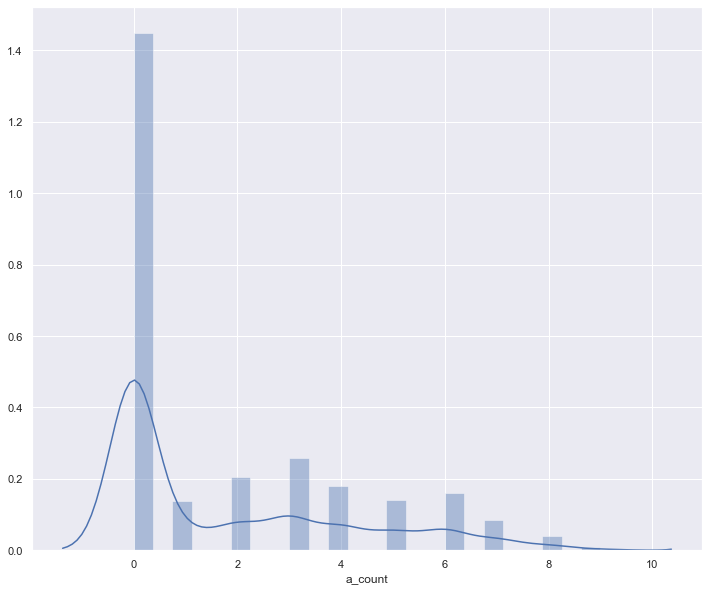

In [170]:
# # Visualize sample distribution for normality 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(df_STEM_donald["a_count"])

In [171]:
#non-normal, random sampling

donald_norm = create_sample_distribution(df_STEM_donald['a_count'], dist_size=1200, n=50)


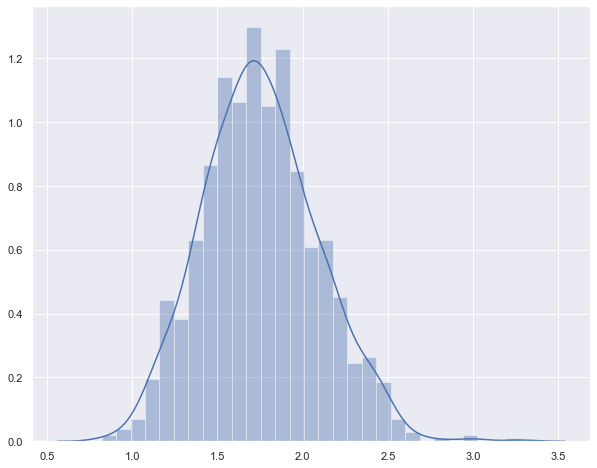

In [172]:
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(donald_norm)

In [87]:
# checking normality with NormalTest from Scipy
import scipy.stats as st
st.normaltest(donald_norm)

NormaltestResult(statistic=0.9289197889066048, pvalue=0.6284744560784284)

In [88]:
donald_norm_mean = np.mean(donald_norm)
donald_norm_mean

1.7668

In [173]:
#running z-test
import math
import scipy.stats as stats
mu = popmean
sigma = popstd
n=50
x_bar = donald_norm_mean
z = (x_bar - mu)/(sigma/math.sqrt(n))
p = 1 - stats.norm.cdf(z)

p,z

(0.9810414841925539, -2.0757505112724703)

#### Interpretation:

P-value is much higger than 0.05, therefore, we have failed to reject the null which means that Donald Yandow has no correalation to the number of As earned in his STEM courses.

#### Taking an instructor from Humanities 

In [174]:
#Do the same thing to HUM courses
df_HUM = teachings[teachings["subjects_name"].isin(HUM)]
df_HUM.head()

,id,name,a_count,course_name,subjects_name
2287,4432700,REBECCA GENAUER,1,Intro to Speech Composition,Communication Arts
2288,4432700,REBECCA GENAUER,3,Intro to Speech Composition,Communication Arts
2289,4432700,REBECCA GENAUER,3,Intro to Speech Composition,Communication Arts
2290,4432700,REBECCA GENAUER,3,Intro to Speech Composition,Communication Arts
2291,4432700,REBECCA GENAUER,2,Intro to Speech Composition,Communication Arts


In [175]:
#taking the instructor giving the most As in humanities courses
df_HUM["name"].value_counts()

IDA BALDERRAMA-TRUDELL    1920
ALBERTA GLORIA            1791
MARC KLEIJWEGT            1766
KELLI RICHARDS            1617
ERIK WRIGHT               1563
                          ... 
VELCHERU NARAYANA RAO        1
JOAN HONG                    1
STACEY LYNN PELIKA           1
JEEWON YOO                   1
RICK SCHELTHELM              1
Name: name, Length: 5334, dtype: int64

In [177]:
#choosing Nicholas Hill as the instructor to compare to the whole population
#does he have a statistically significant correalation with the number of As earned in a course
df_HUM_ida = df_HUM[df_HUM["name"] == "IDA BALDERRAMA-TRUDELL"]
df_HUM_ida

,id,name,a_count,course_name,subjects_name
198124,3012257,IDA BALDERRAMA-TRUDELL,0,Human Dev: Ed Effectiveness,Counseling Psychology
198125,3012257,IDA BALDERRAMA-TRUDELL,8,Human Dev: Ed Effectiveness,Counseling Psychology
198126,3012257,IDA BALDERRAMA-TRUDELL,0,Human Dev: Ed Effectiveness,Counseling Psychology
198127,3012257,IDA BALDERRAMA-TRUDELL,13,Human Dev: Ed Effectiveness,Counseling Psychology
198128,3012257,IDA BALDERRAMA-TRUDELL,15,Human Dev: Ed Effectiveness,Counseling Psychology
...,...,...,...,...,...
215725,3012257,IDA BALDERRAMA-TRUDELL,0,Human Dev: Ed Effectiveness,Counseling Psychology
215726,3012257,IDA BALDERRAMA-TRUDELL,6,Human Dev: Ed Effectiveness,Counseling Psychology
215727,3012257,IDA BALDERRAMA-TRUDELL,25,Human Dev: Ed Effectiveness,Counseling Psychology
215728,3012257,IDA BALDERRAMA-TRUDELL,5,Human Dev: Ed Effectiveness,Counseling Psychology


In [178]:
df_HUM_ida.course_name.unique()

array(['Human Dev: Ed Effectiveness'], dtype=object)

In [179]:
df_HUM_ida["a_count"] = convert_to_integer(df_HUM_ida["a_count"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


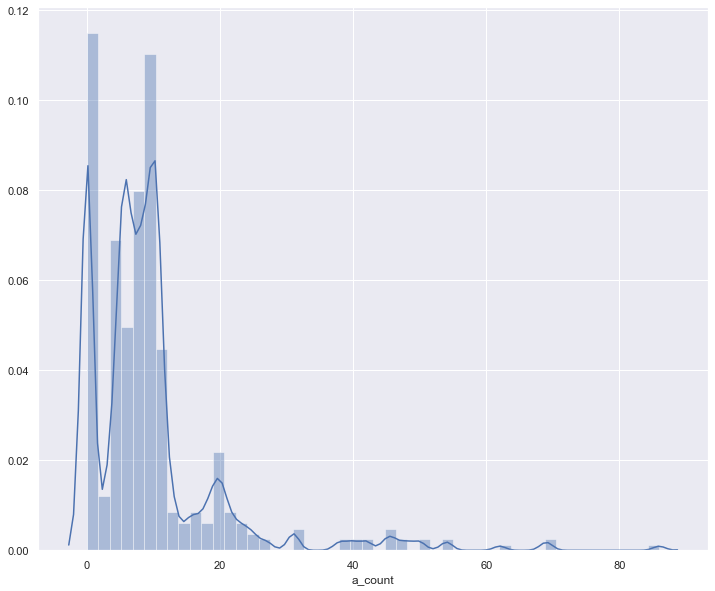

In [180]:
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(df_HUM_ida["a_count"])

In [181]:
#non-normal distribution
ida_norm = create_sample_distribution(df_HUM_ida['a_count'], dist_size=10000, n=50)

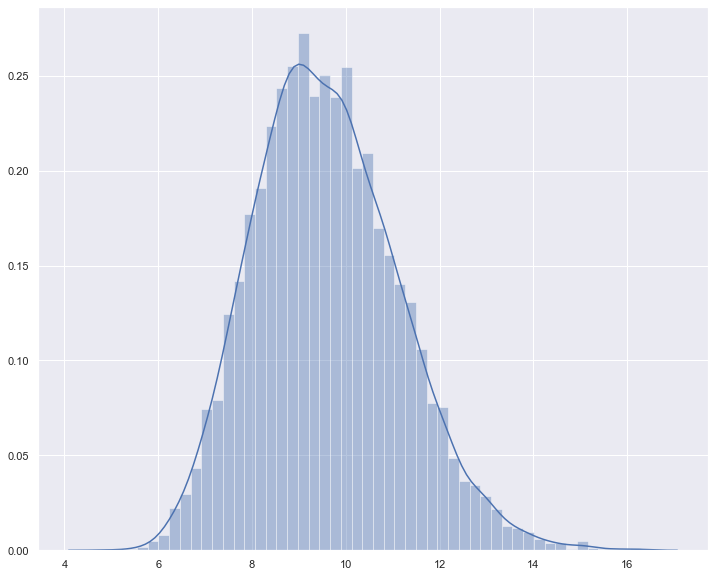

In [182]:
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(ida_norm)

In [184]:
ida_norm_mean = np.mean(nicholas_norm)
ida_norm_mean

27.749131999999996

In [185]:
#running z-test

mu = popmean
sigma = popstd
n=50
x_bar = ida_norm_mean
z = (x_bar - mu)/(sigma/math.sqrt(n))
p = 1 - stats.norm.cdf(z)

p,z

(8.104628079763643e-15, 7.6782220614820265)

#### Interpretation:

P-value is much lower than 0.05, therefore, we reject the null which means that Ida has some correlation to the number of As earned in his humanity courses.

### Comparing Donald and Ida

H0 = There is no difference between the As given by Donald and Ida

H1 = There is difference between the As given by Donald and Ida

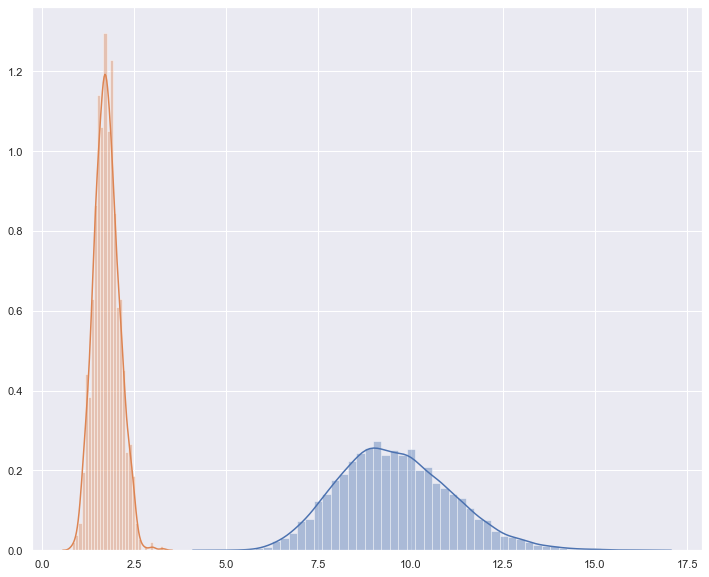

In [186]:
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(ida_norm)
sns.distplot(donald_norm)

In [ ]:
def find_t_crit(sample1, sample2, alpha):
    return stats.t.ppf(1-(alpha/2), (len(sample1)+len(sample2)-2))

find_t_crit(ida_norm, donald_norm, 0.05)

In [ ]:
def two_sample_ttest_student_t(sample1, sample2, alpha):
    return stats.ttest_ind(sample1, sample2, equal_var=False)

two_sample_ttest_student_t(ida_norm, donald_norm, 0.05)

In [193]:
# running a Two Sample T-test
two_sample_ttest(ida_norm, donald_norm, 0.05)
ES, power = power_and_effect_size(ida_norm, donald_norm, 0.05)
print("Cohen_d Effect Size:", ES, "\nPower:", power)

Two Tail T-test:
---------------------------------------------------------------
Obs Number: Sample_1 = 10000   Sample_2 = 1200
Sample Means: Sample_1 = 9.586   Sample_2 = 1.753
Mean Differance: 7.833
---------------------------------------------------------------
t-crit: 1.9601758548119323 
t-stat: 176.5425106520741 
P-value: 0.0 
Alpha(2-Tail): 0.025
---------------------------------------------------------------
|t_stat| > t_crit: True
P_value < Alpha(2-Tail): True

Reject Null_H! The results are statistically significant.
---------------------------------------------------------------
Cohen_d Effect Size: 5.39 
Power: 1.0


In [ ]:
#since the two sample size are different, we run a Welch's test
def welch_t(a, b):
    
    """ Calculate Welch's t-statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

# calculate t-score and the degrees of freedom for the two samples, a and b
t = welch_t(ida_norm, donald_norm)
df = welch_df(ida_norm, donald_norm)
print(t,df)



In [ ]:
#p-value for Welch's t-test
p = 1 - stats.t.cdf(t, df)
print(p)

#### Interpretation

There is a statistically significant difference between the numbers of As given by Ida and Donald.

In [145]:
# since the distribution do not overlap, we are going to take the percentage of students getting As from both instructors
# so then we can compare the difference in percentage
cur.execute("""SELECT F.name AS instructor, section_type, D.name AS CourseName, H.name AS SubjectName, 
                SUM(a_count), SUM(b_count), SUM(c_count), SUM(d_count), SUM(f_count), SUM(u_count),
                (SUM(a_count)+ SUM(b_count)+ SUM(c_count)+ SUM(d_count)+ SUM(f_count)+ SUM(u_count)) AS Total
                
                FROM [teachings] A
                
                JOIN [sections] B
                ON (A.section_uuid = B.uuid)
                JOIN [course_offerings] C
                ON (B.course_offering_uuid = C.uuid)
                JOIN [courses] D
                ON (C.course_uuid = D.uuid)
                JOIN [grade_distributions] E
                ON ((B.course_offering_uuid = E.course_offering_uuid))
                JOIN [instructors] F
                ON (A.instructor_id = F.id)
                JOIN [subject_memberships] G
                ON (B.course_offering_uuid = G.course_offering_uuid)
                JOIN [subjects] H
                ON (G.subject_code = H.code)
                
                GROUP BY instructor
                """)
df_teachings = pd.DataFrame(cur.fetchall())
df_teachings.columns = [x[0] for x in cur.description]
df_teachings.head(20)

,instructor,section_type,CourseName,SubjectName,SUM(a_count),SUM(b_count),SUM(c_count),SUM(d_count),SUM(f_count),SUM(u_count),Total
0,JR. JAMES BROWN,SEM,First-Year Seminar in the Humanities,Interdisciplinary Courses (L&S),289,91,17,5,5,0,407
1,M.D. ELIZABETH A JACOBS,IND,Independent Study,Medicine,164,2,0,0,0,0,166
2,- EKTA,LAB,Introduction to Data Programming,Computer Sciences,81,74,9,3,3,0,170
3,. ABHINAVA,DIS,General Physics,Physics,1588,1646,380,58,30,0,3702
4,. LEAH TOM,LAB,General Physics,Physics,324,400,460,8,8,0,1200
5,. MITCH,FLD,Clinical Program,Law,1,0,0,0,0,3,4
6,. NEHARIKA,LAB,Fundamentals of Electrical and Electro-mechani...,Electrical and Computer Engineering,132,140,26,8,0,0,306
7,. P KRISHNA,LAB,Engineering Measurements and Instrumentation,Mechanical Engineering,96,356,56,4,0,0,512
8,. PRASHANSA,LAB,Fluid Mechanics,Civil and Environmental Engineering,11,31,8,2,0,0,52
9,. RAJSHEKHAR,LAB,Process Dynamics and Control,Chemical and Biological Engineering,7,3,6,0,0,0,16


In [146]:
df_teachings['a_percentage'] = df_teachings['SUM(a_count)']/df_teachings["Total"]

In [149]:
df_teachings.sort_values(by=['a_percentage'], inplace=True, ascending=False)
df_teachings

,instructor,section_type,CourseName,SubjectName,SUM(a_count),SUM(b_count),SUM(c_count),SUM(d_count),SUM(f_count),SUM(u_count),Total,a_percentage
14002,PIN-CHIA SU,LAB,Pedagogy,Music,7,0,0,0,0,0,7,1.0
15184,SALLY CHISHOLM,IND,Elementary/Intermediate Viola,Music-Performance,133,0,0,0,0,0,133,1.0
15180,SALIH EMINAGA,FLD,Small Animal Neurology,Medical Sciences - Veterinary Medicine,1,0,0,0,0,0,1,1.0
6156,GREGORY WAIDLEY,SEM,Colloquium in Transportation Management and Po...,Civil and Environmental Engineering,134,0,0,0,0,0,134,1.0
6150,GREGORY SMITH,SEM,A Wisconsin Experience Seminar,Counseling Psychology,9,0,0,0,0,0,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18126,YAOHUI XU,FLD,Independent Reading and Research for Fourth Ye...,Medicine,0,0,0,0,0,0,0,NaN
18173,YI-CHEN LEE,FLD,Elementary Teaching Practicum II,Curriculum and Instruction,0,0,0,0,0,0,0,NaN
18266,YORAM SHENKER,FLD,Endocrinology Clerkship,Medicine,0,0,0,0,0,0,0,NaN
18282,YOUNG K LEE,FLD,Clinical Anesthesia Clerkship-LaCrosse,Anesthesiology,0,0,0,0,0,0,0,NaN


In [187]:
df.teachings_ida = df_teachings[df_teachings["instructor"] == "IDA BALDERRAMA-TRUDELL"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [189]:
# Ida's As percentage
df.teachings_ida

,instructor,section_type,CourseName,SubjectName,SUM(a_count),SUM(b_count),SUM(c_count),SUM(d_count),SUM(f_count),SUM(u_count),Total,a_percentage
6733,IDA BALDERRAMA-TRUDELL,LEC,Human Resources Development: Educational Effec...,Counseling Psychology,18404,812,172,132,196,0,19716,0.933455


In [157]:
df.teachings_donald = df_teachings[df_teachings["instructor"] == "DONALD YANDOW"]

In [190]:
# Donald's As percentage
df.teachings_donald

,instructor,section_type,CourseName,SubjectName,SUM(a_count),SUM(b_count),SUM(c_count),SUM(d_count),SUM(f_count),SUM(u_count),Total,a_percentage
4609,DONALD YANDOW,FLD,Radiology Clerkship,Radiology,6509,3520,24,0,0,0,10053,0.647468


#### Interpretations

Almost 65% of students attending Donald Yandow's Radiology class get A grades while 93% of students attending Ida Trudell's Astronomy class can earn a grades. This somehow support our results from One Sample T-tests that Ida has some correlation with the number of As she gives.

## Q3: Do section types have a statistically significant correalation with the number of As earned in a course?

#### Null Hypothesis

The number for A's achieved is NOT related to the section type


#### Alternative Hypothesis

The number for A's achieved is related to the section type


In [110]:
cur.execute("""SELECT grade_distributions."a_count", sections."number", sections."section_type" FROM grade_distributions
            JOIN sections ON grade_distributions."course_offering_uuid" = sections."course_offering_uuid";""")
sections = pd.DataFrame(cur.fetchall())
sections.columns = [x[0] for x in cur.description]
sections

,a_count,number,section_type
0,105,1,FLD
1,158,1,FLD
2,139,1,FLD
3,139,1,FLD
4,139,1,FLD
...,...,...,...
2077511,18,1,SEM
2077512,18,1,SEM
2077513,18,1,SEM
2077514,0,7,LEC


In [111]:
sections["section_type"].unique()

array(['FLD', 'LAB', 'LEC', 'IND', 'DIS', 'SEM'], dtype=object)

In [112]:
# new dataframe for each type
FLD = sections.loc[sections['section_type'] == 'FLD']
LAB = sections.loc[sections['section_type'] == 'LAB']
LEC = sections.loc[sections['section_type'] == 'LEC']
IND = sections.loc[sections['section_type'] == 'IND']
DIS = sections.loc[sections['section_type'] == 'DIS']
SEM = sections.loc[sections['section_type'] == 'SEM']
print(FLD.shape)
print(LAB.shape)
print(LEC.shape)
print(IND.shape)
print(DIS.shape)
print(SEM.shape)

(70241, 3)
(170147, 3)
(398828, 3)
(1216983, 3)
(153845, 3)
(67472, 3)


In [114]:

FLD["a_count"] = convert_to_integer(FLD["a_count"])
LAB["a_count"] = convert_to_integer(LAB["a_count"])
LEC["a_count"] = convert_to_integer(LEC["a_count"])
IND["a_count"] = convert_to_integer(IND["a_count"])
DIS["a_count"] = convert_to_integer(DIS["a_count"])
SEM["a_count"] = convert_to_integer(SEM["a_count"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

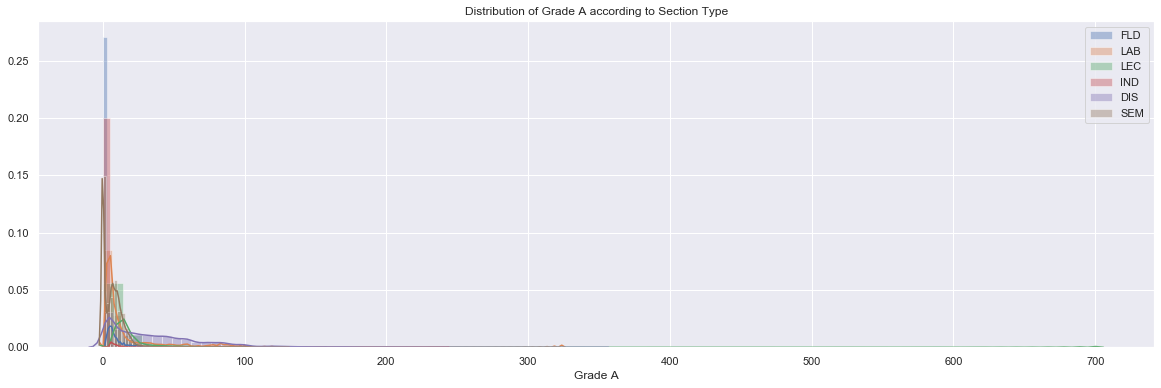

In [115]:
plt. figure(figsize=(20,6))

# distribution of As for each of them
sns.distplot(FLD['a_count'], label="FLD")
sns.distplot(LAB['a_count'], label="LAB")
sns.distplot(LEC['a_count'], label="LEC")
sns.distplot(IND['a_count'], label="IND")
sns.distplot(DIS['a_count'], label="DIS")
sns.distplot(SEM['a_count'], label="SEM")

plt.title("Distribution of Grade A according to Section Type")
plt.xlabel("Grade A")

plt.legend()
plt.show()

In [116]:
#very skewed distributed
#normalization
# Create Random Smaples:
FLD_norm = create_sample_distribution(FLD['a_count'], dist_size=10000, n=50)
LAB_norm = create_sample_distribution(LAB['a_count'], dist_size=10000, n=50)
LEC_norm = create_sample_distribution(LEC['a_count'], dist_size=10000, n=50)
IND_norm = create_sample_distribution(IND['a_count'], dist_size=10000, n=50)
DIS_norm = create_sample_distribution(DIS['a_count'], dist_size=10000, n=50)
SEM_norm = create_sample_distribution(SEM['a_count'], dist_size=10000, n=50)

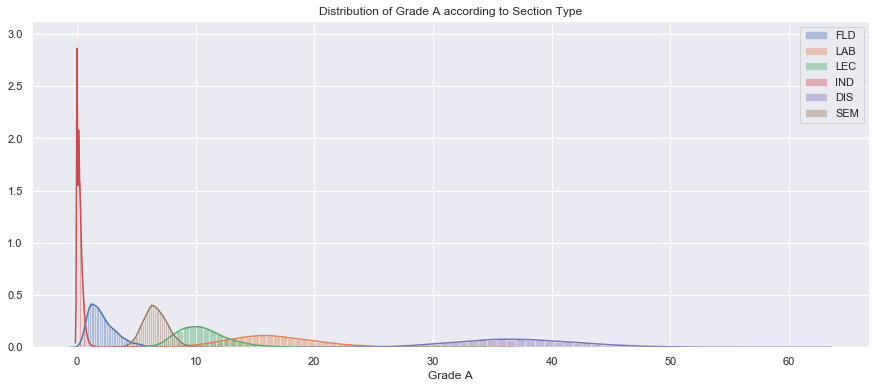

In [117]:
plt. figure(figsize=(15,6))

# distribution of As for each of them
sns.distplot(FLD_norm, label="FLD")
sns.distplot(LAB_norm, label="LAB")
sns.distplot(LEC_norm, label="LEC")
sns.distplot(IND_norm, label="IND")
sns.distplot(DIS_norm, label="DIS")
sns.distplot(SEM_norm, label="SEM")

plt.title("Distribution of Grade A according to Section Type")
plt.xlabel("Grade A")

plt.legend()
plt.show()

In [118]:
# multicomparison
section_a_grade = sections['section_type'].unique()
list(itertools.combinations(section_a_grade, 2))

[('FLD', 'LAB'),
 ('FLD', 'LEC'),
 ('FLD', 'IND'),
 ('FLD', 'DIS'),
 ('FLD', 'SEM'),
 ('LAB', 'LEC'),
 ('LAB', 'IND'),
 ('LAB', 'DIS'),
 ('LAB', 'SEM'),
 ('LEC', 'IND'),
 ('LEC', 'DIS'),
 ('LEC', 'SEM'),
 ('IND', 'DIS'),
 ('IND', 'SEM'),
 ('DIS', 'SEM')]

In [119]:
sections["a_count"] = convert_to_integer(sections["a_count"])

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
   DIS    FLD -35.0648 0.001 -35.2563 -34.8733   True
   DIS    IND -36.9424 0.001 -37.0562 -36.8286   True
   DIS    LAB -20.7669 0.001 -20.9148 -20.6189   True
   DIS    LEC -26.4714 0.001 -26.5976 -26.3452   True
   DIS    SEM -30.5647 0.001 -30.7589 -30.3705   True
   FLD    IND  -1.8777 0.001  -2.0409  -1.7145   True
   FLD    LAB  14.2979 0.001  14.1093  14.4865   True
   FLD    LEC   8.5934 0.001   8.4213   8.7655   True
   FLD    SEM   4.5001 0.001   4.2734   4.7267   True
   IND    LAB  16.1756 0.001  16.0667  16.2844   True
   IND    LEC  10.4711 0.001  10.3943  10.5478   True
   IND    SEM   6.3777 0.001   6.2114    6.544   True
   LAB    LEC  -5.7045 0.001  -5.8263  -5.5827   True
   LAB    SEM  -9.7978 0.001  -9.9891  -9.6065   True
   LEC    SEM  -4.0933 0.001  -4.2684  -3.9183   True
----------------------------

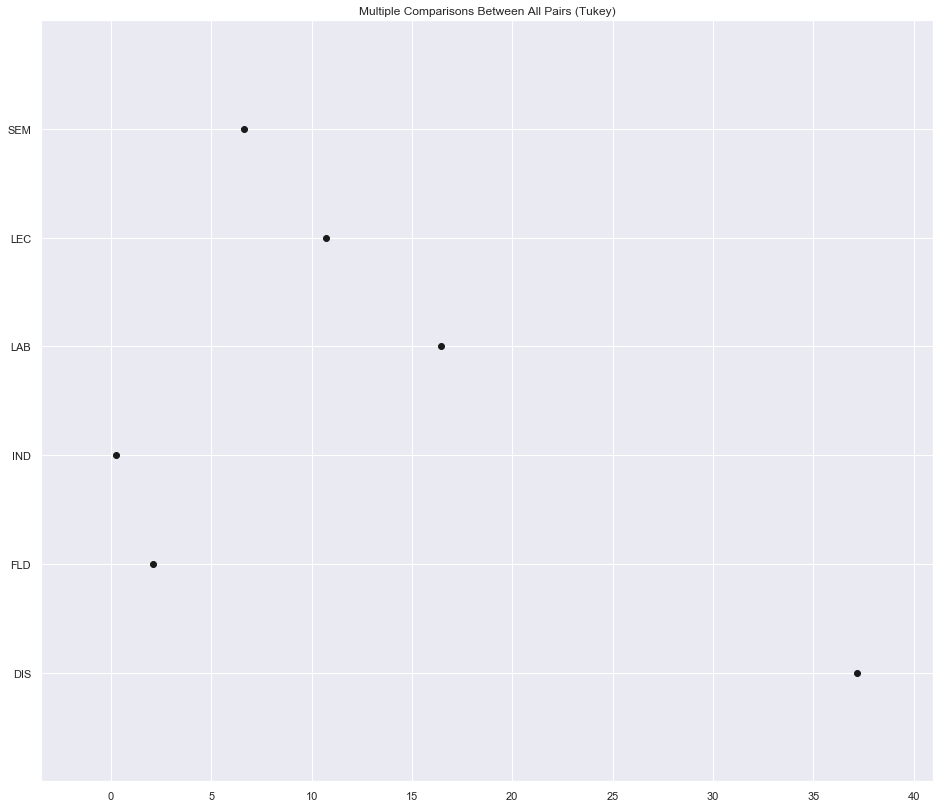

In [125]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(sections['a_count'], sections['section_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

mc_results = mc_results.plot_simultaneous(figsize=(16,14))
plt.show()


#### Interpretations

The Tukey Test has shown that there are difference of getting As by attending different types of studies. Directed Studies seems to have a statistically significant correalation with grade As eanred in courses, followed by labs and lectures.

# Findings

Science & Engineering obtains statistically more "As" than the Humanities & Social Science

STEM instructor - Donald Yandow has no statistically significant correlation with the number of As earned in his courses

Humanities instructor - Ida Trudell has a statistically significant correlation with the number of As earned in her courses

Directed Studies. labs and lectures seem to have a statistically significant correlation with the number of As earned in her courses


# Limitations

The total number of students attending courses from 2006 - 2017 was unknown. The number of students attending each course was unknown as well which made it hard to gather information to run our tests.

It would have been very helpful to include the years of courses to have more information for hypothesis testing.